## Qualitative signaling agent (Twitter agent)

In this notebook, I explain how qualitative signaling agent works, with step-by-step manner.

## Setup

### Setup paths

* Add necessary imports for Google Drive which will be the working directory.
* Change the paths according to where your dataset is.

In [ ]:
from google.colab import drive
import sys, os

#mount google drive
drive.mount('/content/drive', force_remount=False)
# Change folder path so it corresponds to your environment
# COLAB_PATH = '/content/drive/My Drive/'
# change directory to the path above
#os.chdir(COLAB_PATH)

Mounted at /content/drive


### Install libraries

Install relevant libraries.

In [ ]:
!pip install yfinance
!pip install scikit-fuzzy
!pip install snscrape
!pip install nltk
!pip install pymysql

     |████████████████████████████████| 6.3 MB 16.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=2052ce218c616edeb565afbf2c50deb3fb3fafa2d75af28bc80d162bf8391959
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 993 kB 14.1 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=c5848e40b6f4a0fb4127ef33e5c5ae3b2853e82f991d0f370563288825c9efcf
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy
     |████████████████████████████████| 43 kB 1.6 MB/s 


### Import libraries

In [ ]:
#libraries for general purpose
import requests
import numpy as np
import pandas as pd
import pandas as pd
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
import calendar
import warnings
import json
import seaborn as sns
from sqlalchemy import create_engine
warnings.filterwarnings(action='ignore')

In [ ]:
#libraries for qualitative agents (i.e. twitter sentiment)
#libraries for text data preprocessing
import nltk
from nltk.corpus import stopwords
import itertools
import re
import string
from textblob import TextBlob

#libraries for google sentiment analysis and fuzzy logic
import skfuzzy as fuzz
from google.cloud import language_v1
from google.cloud.language_v1 import enums
from skfuzzy import control as ctrl
import snscrape.modules.twitter as sntwitter
from time import sleep

### Create sql alchemy engine

It is used to establish the access to the NUS data library. Regarding NUS data library, please ask to Reshma who is the manager of the database. About the details, pls ask to the administrator of data library at Fintech Lab.

In [ ]:
# create sqlalchemy engine
sqlEngine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}"
                       .format(user="xxxxxx",
                               pw="xxxxxx",
                               db="xxxxxx",
                               host = 'xxx.xxx.xxx.xxx',
                               port = xxxxx))

### Setting up Google sentiment analysis tool for qualitative agent

Please obtain relevant json file from google, and place file under the folder that you've set as COLAB_PATH.

In [1]:
#set up for google sentiment analysis tool in Qualitative agent
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'xxxxxx.json'
#!echo $GOOGLE_APPLICATION_CREDENTIALS

## Explanation and guide for qualitative agent

Qualitative anget is the agent which formulates buy/sell signals based on qualitative data such as text. In our implementation, we try to formulate buy/sell signals by analyzing twitter text sentiment and converting those into trading buy/sell signals, by implementing Twitter agent.

### 1.Data acquisition

* **Data Acquisition**
 
 First of all, we should obtain text data regarding bitcoin from twitter. As the text scraping tool for twitter, it looks that “tweepy” is widely used by many students in past IS5006 class. However, it has the limitation of data acquisition, such as the limitation of available data only for recent 7 days, etc. Considering such limitations, this time, the system applied the “snscrape” library to obtain tweet data several years ago.

* **Set scope of data**

 Next, we need to set the scope of data acquisition. While we may be able to reach great insight by collecting all worldwide tweets regarding bitcoin and cryptocurrencies, gathering such tremendous amounts of data is computationally too expensive.
 
 Also, as we gather tweets from less popular and unreliable accounts, the quality of information can saturate and the amount of noise in text information can increase. With regard to this point, the sentiment of popular twitter news accounts such as NYTimes, Bloomberg, CNN News, etc, have high correlation with market price. Based on those surveys, this time, we have chosen Wall Street Journal (WSJ), Bloomberg, Investing.com, CNN, NYTimes, Financial Times (FT), and Elon Musk.
 
 Elon Musk is not the news media but an individual, but nowadays his tweet has influential power toward bitcoin and other cryptocurrency’s price, such that I included his twitter account within data gathering scope.
 
 I collected data from 2014 with 7612 tweets, but many of the tweets are recent one after 2018, when bitcoin price showed a bubble and burst with large price movement. Then, we added those data into SQL data library. The system obtains those data from SQL database then stores data into the dataframe of self.tweets_hist_df.

### 2.Data preprocessing

In text sentiment analysis, data preprocessing takes a very important part. 

* **Cleaning up the texts**

 First of all, we need to clean up twitter text. For example, we remove strings starting with “@”, “#”, “$”. Also, we remove hyperlinks and URL, video, and “RT”, etc, the words which are not important to evaluate the sentiment.


* **Eliminating stop words**

 Also, we can eliminate stop-words. Stop-words means meaningless words such as “a”, “the”, “of”, and so on. The system executes those tasks by the functions of clean_tweet_text(self, tweetText) and removeStopwords(self, text), when twitterSignal class executes the function of dataPreprocessing(self).
 
 When we deal with stopwords, nltk (Natural Language ToolKit) library is popularly used, so I introduced it in the system implementation. Those preprocessing can remove noise in text data, such that it affects the quality of sentiment analysis significantly.

### 3.Data transformation

In addition to the data preprocessing, we can transform text data to convert those into quantified sentiment data.

* **Textblob**

 For example, I introduced sentiment measurement of “polarity” and “subjectivity” by using the textblob library.Obtaining polarity and subjectivity by using textblob is a very simple, but powerful way to start text sentiment analysis.
 
 - Polarity is a float within the range [-1.0, 1.0], where 1 means positive statement and -1 means a negative statement.
 
 - Subjectivity is a float within the range [0.0, 1.0] where 0 is objective and 1.0 is subjective. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. 

* **Google Text Analytics**

 To move one step ahead for the text sentiment analysis, the system utilized Google Text Analytics in the function of googleSentiment(self, df). By utilizing this function, we can obtain text sentiment metrics such as “score” and “magnitude”.

 - Score: It ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

 - Magnitude: It indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes). 

 In addition, by using Google Text Analytics, we can obtain other information such as the category of the topic that the text mentions (e.g. finance, leisure, etc). As a result, we can gather data shown as follows.



### 4.Fuzzy logic

After obtaining sentiment metrics by using google text analytics, the system implements the fuzzy logic to convert “score” and “magnitude” into one integrated sentiment indicator of “strength”.

* First, we set membership functions for score, magnitude, and strength. For example, by setting membership functions for score and magnitude, we can define “how much of the score is regarded as low score i.e. negative, how much is mediocre i.e. neutral, and how much is positive” in a “fuzzy” manner.

* Then, the fuzzy logic can output the final integrated sentiment outcome as “strength” by combining “score” and “magnitude”.

Fuzzy-logic is a relatively old idea which was introduced around 1965 and used for the temperature control of rice cookers and electric ovens. However, it is still useful when we deal with “vague” recognition, such as “hot” or “cold” for rice cookers and “positive” and “negative” in text tone. By utilizing fuzzy logic, we can deal with the vagueness in the use of language such as “positive” or “negative” tone in text.

### Final outcome

Finally, we can obtain a “strength” sentiment indicator between 0-100, shown below in the graph.

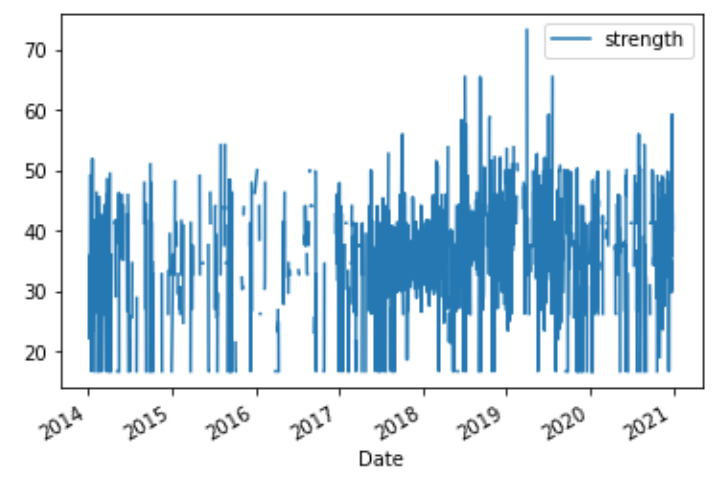

## Whole code of the agent

In [ ]:
class twitterSignal():

  ###########################
  #Twitter text data related
  ###########################
  #For stopword operation.
  nltk.download('stopwords')

  #initilization by obtaining past some days of data
  def __init__(self, day, backtest=False):

    #set backtest / realtime mode
    self.backtest = backtest

    #initialize dataframes
    self.agent3_hist_signal_df = pd.DataFrame()
    self.sentiment_history_df = pd.DataFrame()
    self.tweets_df = pd.DataFrame()

    self.twitterTextInitialization()
    
    #In trading mode, we obtain recent data and do data preprocessing 
    #and fuzzy logic to obtain recent twitter indicator
    if self.backtest == False:
      #collect last 10 days of twitter sentiment data
      start = day + datetime.timedelta(days=-11)
      end = day + datetime.timedelta(days=-1)

      self.textAcquisition(start, end)
      self.dataPreprocessing()
      self.fuzzyLogic()

  '''
  #############################
  #It's just for reference to obtain twitter data from scratch.
  #After implementing SQL inhouse data library, we won't use it.
  #############################

  #it takes very long time to obtain many years of twitter data.
  #so, we download data only once and save it as csv file.
  def backtestDataAcquisition(self):

    self.sentiment_history_df = pd.DataFrame()

    for year in range(2014,2021):
      start = datetime.datetime(year,1,1)
      end = datetime.datetime(year,12,31) + datetime.timedelta(Days=1)

      self.textAcquisition(start, end)
      self.dataPreprocessing()
      self.fuzzyLogic()
      self.tweets_df.to_csv('twitter_data/twitterdata_{}.csv'.format(year))
      print('twitter year {} is downloaded'.format(year))

    self.sentiment_history_df.to_csv('twitter_data/fuzzysentimentdata.csv')

  #Twitter data acquisition tool
  #Once NUS database is completed, we won't use it
  def textAcquisition(self, startday, endday):

    #convert datetime into text format
    startday = startday.strftime('%Y-%m-%d') 
    endday = endday.strftime('%Y-%m-%d') 
    #set the num of break iteration
    break_iter = 9999
    #empty list for twetter data storing.
    tweets_list = []
    #It's column list for pd dataframe.
    column_list = ['crypto','url','date','id', 'username', 'content']
    #so far, we set only popular cryptos.
    word_list = ['bitcoin', 'btc']
    #We extract data only from low noise, high quality news media's accounts.
    #note: 'business' is bloomberg's official news account.
    account_list = ['WSJ','business','Investingcom','CNN','nytimes','FT','elonmusk']

    for search in itertools.product(word_list,account_list):
      #example of search_word: 'bitcoin from:WSJ since:2013-01-01 until 2020-12-31'
      search_word = str(search[0]) + ' from:' + str(search[1]) + ' since:' + startday + ' until:' + endday
      for i, tweet in enumerate(sntwitter.TwitterSearchScraper(search_word).get_items()):
        if i> break_iter:
            break
        tweets_list.append([search[0], tweet.url, tweet.date,tweet.id, tweet.username, tweet.content])
      
    if len(tweets_list) == 0:
      tweets_list.append([np.nan,np.nan,startday,np.nan, np.nan, np.nan])
    
    self.tweets_df = pd.DataFrame(tweets_list, columns=column_list).sort_values('date')
  '''

  #obtain twitter data from SQL data library and data preprocessing
  def twitterTextInitialization(self):
    dbConnection = sqlEngine.connect()
    self.tweets_hist_df = pd.read_sql("select * from Tweets", dbConnection).sort_values('date').reset_index(drop=True)
    dbConnection.close()

  #getter of twitterAgent.tweets_df
  def textAcquisition(self, start, end):
    startday = start
    endday = end + datetime.timedelta(days=1)
    self.tweets_df = self.tweets_hist_df[(self.tweets_hist_df['date'] >= startday) &  (self.tweets_hist_df['date'] <= endday)]

    if len(self.tweets_df) == 0:
      self.tweets_df.loc[0] = np.nan
      self.tweets_df.loc[0,'date'] = startday

  ###########################
  #Text data preprocessing
  ###########################

  def dataPreprocessing(self):
    
    #if there is text data in certain day, below is executed
    try:
      #add text length for twitter data
      self.tweets_df['text_length'] = self.tweets_df['content'].apply(len)
      #Apply clean_up_tweet and removeStopwords to twitter's text
      self.tweets_df['content_processed'] = self.tweets_df['content']\
                                                    .apply(self.clean_tweet_text)\
                                                    .apply(self.removeStopwords)
      #Add polarity and subjectivity
      self.tweets_df['polarity'] = self.tweets_df['content_processed'].apply(self.get_text_polarity)
      self.tweets_df['subjectivity'] = self.tweets_df['content_processed'].apply(self.get_text_subjectivity)
      self.tweets_df['label'] = self.tweets_df['polarity'].apply(self.get_text_analysis)
      #add text length for twitter data
      self.tweets_df['text_processed_length'] = self.tweets_df['content_processed'].apply(len)
      #Add google sentiment data
      result_df = self.googleSentiment(self.tweets_df)
      self.tweets_df = self.tweets_df.merge(result_df, how='inner', on=result_df.index).drop('key_0', axis=1)

    #when no text data is available, it returns error and transact as follows
    except:
      self.tweets_df[['text_length','content_processed','polarity','subjectivity',
                      'label','text_processed_length']] = np.nan

  #Preprocessing 1...text clearning tool which is unique for twitter text
  def clean_tweet_text(self, tweetText):
    # Change all characters to lower case
    tweetText = tweetText.lower() 
    # Remove any strings starting with a "@"
    tweetText = re.sub("@[A-Za-z0-9]+", "", tweetText) 
    # Remove any strings starting with a "#"
    tweetText = re.sub("#[A-Za-z0-9]+", "", tweetText) 
    # Remove any strings starting with a "$"
    tweetText = re.sub("\$[A-Za-z]+", "", tweetText) 
    # Remove the "\n" string
    tweetText = re.sub("\\n", " ", tweetText) 
    # Remove any hyperlinks
    tweetText = re.sub("https?:\/\/\S+", "", tweetText) 
    # Remove url/website that didn't use http, is only checking for .com websites,
    # so words that are seperated by a . are not removed
    tweetText = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', tweetText)
    # Remove {link}
    tweetText = re.sub(r'{link}', '', tweetText) 
    # Remove &text; html chars
    tweetText = re.sub(r'&[a-z]+;', '', tweetText) 
    # Remove [video]
    tweetText = re.sub(r"\[video\]", '', tweetText) 
    # Remove all remaining characters that aren't letters, white space, or 
    #the following #:)(/\='] that are used in emojis or hashtags
    tweetText = re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];='#$]", '', tweetText)
    # Remove retweets:
    tweetText = re.sub(r'RT : ', '', tweetText)

    # Return the cleaned tweet text to the caller
    return tweetText

  #Preprocessing 2...removing stop-words i.e. a, the, of, etc
  #function to execute removing stopwords.
  def removeStopwords(self, text): 
    stop = stopwords.words('english')

    text = text.lower()
    regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n'+']')
    txt = regex.sub('',text)  #remove punctuation
    # remove stop words and words with length smaller than 3 letters
    words = [w for w in txt.split(' ') if w not in stop] 
    words = ' '.join(word for word in words)

    return words

  ###########################
  #Data transformation
  #Subjectivity and polarity data
  ###########################

  #subjectivity: [0,1]. 0=objective fact, 1=subjective opinion
  def get_text_subjectivity(self, txt):
      return TextBlob(txt).sentiment.subjectivity

  #polarity:[-1,1]. -1=very negative tone, +1=very positive tone.
  def get_text_polarity(self, txt):
      return TextBlob(txt).sentiment.polarity

  # categorize our tweets as Negative, Neutral and Positive.
  #1=very negative, 5=very positive
  def get_text_analysis(self, polarity):
      if (polarity < 0 and polarity > -0.5):
          return 2
      elif polarity <= -0.5:
          return 1
      elif polarity == 0:
          return 3
      elif (polarity > 0 and polarity < 0.5):
          return 4
      else:
          return 5

  ###########################
  #Data transformation
  #Sentiment analysis by google text analyzer
  ###########################

  #google sentiment function
  def googleSentiment(self, df):

    # setup a client for the service
    client = language_v1.LanguageServiceClient()

    # specify the type and language of the document we want to analyse
    type_ = enums.Document.Type.PLAIN_TEXT
    language = "en"
    result_df_score_mag = pd.DataFrame(columns= ['tweet_num','score','magnitude'])

    for index, row in df.iterrows():
      text_content = row['content']

      # assign metadata parameters
      document = {"content": text_content, "type": type_, "language": language}
      encoding_type = enums.EncodingType.UTF8

      # invoke the analyze_sentiment API
      response = client.analyze_sentiment(document, encoding_type)
      # invoke the analyze_entities API for bonus 2
      # i.e. adding insight regarding what the tweet is about. Example: Phone, Organisation etc.
      entities_response = client.analyze_entities(document, encoding_type)

      # invoke classify_text API for bonus 2
      # i.e. adding insight regarding category, such as finance, investing, currencies etc,
      detected_categories = None
      try:
        categories_response = client.classify_text(document)
        
        categories = set()
        for category in categories_response.categories:
          categories.add(category.name)

        detected_categories = ",".join(categories)
      
      #if we cannot find any categories, we just pass it
      except:
        pass

      # simple method used to slow down the requests due to too many requests error
      sleep(0.2) 
      
      entity_types = set()
      for entity in entities_response.entities:
        entity_types.add(enums.Entity.Type(entity.type).name)

      # store the score and magnitude values into result_df_score_mag
      temp_df = pd.DataFrame([[index,
                              response.document_sentiment.score,
                              response.document_sentiment.magnitude, 
                              entities_response.language,
                              ','.join(entity_types),
                              detected_categories
                              ]], 
                            
                              columns=['tweet_num',
                                      'score',
                                      'magnitude', 
                                      'google_language',
                                      'google_entities',
                                      'google_categories'])
      result_df_score_mag = result_df_score_mag.append(temp_df, ignore_index=True)

    return result_df_score_mag

  #By fuzzy logic, converting google sentiment (score, magnitude) into
  #one indicator of 'strength' between 0 (negative) - 100 (positive).
  #'strength' can be used for trading buy/sell recommendation.
  #i.e. if strength > certain figure, buy.
  #     if strength < certain figure, sell.
  def fuzzyLogic(self):
    #if no text data available, just return nan for sentiment indicator
    if self.tweets_df.iloc[0,:].isna().sum() > 5:
      
      self.sentiment_dailyavg_df = pd.DataFrame(data=[['BTC-USD',np.nan]],
                                                        index=self.tweets_df['date'],
                                                        columns=['currency','strength'])
      self.sentiment_dailyavg_df.index.names = ['Date']

    #else, implement fuzzy logic and return sentiment indicator value of 0-100
    else:
      #check if there is relevant twitter text within the day.
      #If no tweet, we fill sentiment data as N/A
      #if len(twitterAgent.tweets_df) == 0:
      #  twitterAgent.sentiment_dailyavg_df = pd.DataFrame[columns=['currency','strength']]

      #Antecedent: score and magnitude 
      #Consequence: sentiment strength

      #Setup:
      #- Score is -1 to 1 with 0.1 step
      #- Magnitude is 0 to 2.0 with 0.1 step
      #- Strength is 0 to 100, with step = 1
      score = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'score')
      magnitude = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'magnitude')
      strength = ctrl.Consequent(np.arange(0, 101, 1), 'strength')

      #Setting membership function for the score
      score['low'] = fuzz.trimf(score.universe, [-1, -1, 0])
      score['moderate'] = fuzz.trimf(score.universe, [-1.0, 0, 1.0])
      score['high'] = fuzz.trimf(score.universe, [0, 1, 1])

      #setting membership function for the magnitude
      magnitude['low'] = fuzz.trimf(magnitude.universe, [0, 0, 1.0])
      magnitude['moderate'] = fuzz.trimf(magnitude.universe, [0, 1.0, 2.0])
      magnitude['high'] = fuzz.trimf(magnitude.universe, [1.0, 2.0, 2.0])

      #setting membership function for the strength
      strength['low'] = fuzz.trimf(strength.universe, [0, 0, 50])
      strength['moderate'] = fuzz.trimf(strength.universe, [0, 50, 100])
      strength['high'] = fuzz.trimf(strength.universe, [50, 100, 100])

      #The rules are as follows:
      #- Strength will be high if
      #  - Both score and magnitude are high
      #  - Score is high and magnitude is average
      #- Strength will be moderate if
      #  - Score is high but magnitude is low
      #  - Both score and magnitude is average
      #  - Score is average but magnitude is high
      #- Strength will be low if
      #  - Score is average and magnitude is low
      #  - Score is low
      rule1 = ctrl.Rule(score['high'] & magnitude['high'], strength['high'])
      rule2 = ctrl.Rule(score['high'] & magnitude['moderate'], strength['high'])

      rule3 = ctrl.Rule(score['high'] & magnitude['low'], strength['moderate'])
      rule4 = ctrl.Rule(score['moderate'] & magnitude['moderate'], strength['moderate'])
      rule5 = ctrl.Rule(score['moderate'] & magnitude['high'], strength['moderate'])

      rule6 = ctrl.Rule(score['moderate'] & magnitude['low'], strength['low'])
      rule7 = ctrl.Rule(score['low'], strength['low'])

      analysis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
      analysis = ctrl.ControlSystemSimulation(analysis_ctrl)

      # create empty dataframe to store the results of usefulness
      result_df = pd.DataFrame(columns= ['date','strength'])

      for index, row in self.tweets_df.iterrows():
        analysis.input['score'] = row['score']
        analysis.input['magnitude'] = row['magnitude']

        # crunch the numbers
        analysis.compute()

        tempGrade = analysis.output['strength']

        # store Usefulness grade into result_df
        temp_df = pd.DataFrame([tempGrade], columns=['strength'])
        temp_df['date'] = row['date']
        result_df = result_df.append(temp_df, ignore_index=True)

      result_df.columns = ['Date','strength']
      result_df['Date'] = pd.to_datetime(result_df['Date'])
      #create daily average score of twitter sentiment
      self.sentiment_dailyavg_df = result_df.resample('d', on='Date').mean()
      self.sentiment_dailyavg_df.index = self.sentiment_dailyavg_df.index.strftime('%Y-%m-%d')
      self.sentiment_dailyavg_df['currency'] = 'BTC-USD'
      self.sentiment_dailyavg_df = self.sentiment_dailyavg_df[['currency','strength']]

    #convert the data type of index 'yyyy-mm-dd' into datetime
    self.sentiment_dailyavg_df.index = pd.to_datetime(self.sentiment_dailyavg_df.index)

    #store twitter sentiment indicator
    try:
      self.sentiment_history_df = pd.concat([self.sentiment_history_df,
                                                     self.sentiment_dailyavg_df])
    #if no sentiment_history_df, set up dataframe by today's data
    except:
      self.sentiment_history_df = self.sentiment_dailyavg_df
    
    self.sentiment_history_df.index.names = ['Date']

    #set start and end day in the data
    startday = self.sentiment_history_df.index[0]
    endday = self.sentiment_history_df.index[-1]
    #Change data from 250 trading days per year excluding holidays to 365 days data.
    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    #Add saturday and sunday.
    self.sentiment_history_df = self.sentiment_history_df.reset_index()
    self.sentiment_history_df = date_df.merge(self.sentiment_history_df, on='Date', how='outer')
    #change datetype of Date
    self.sentiment_history_df['Date'] = self.sentiment_history_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    self.sentiment_history_df['currency'] = self.sentiment_history_df['currency'].fillna(method='ffill')
    #set Date as index.
    self.sentiment_history_df = self.sentiment_history_df.set_index(['Date'])
    #for keeping data cleanness, executing elimination of duplicated day data
    self.sentiment_history_df = self.sentiment_history_df[~self.sentiment_history_df.index.duplicated(keep='first')]

  def signalGeneration(self, sentiment_history_df, day, data_window=1, buy_level=40, sell_level=20):
    sentiment_df = sentiment_history_df.copy()
    #for keeping data cleanness, executing elimination of duplicated day data
    sentiment_df = sentiment_df[~sentiment_df.index.duplicated(keep='first')]

    #rolling x days moving average
    sentiment_df['strength_ma'] = sentiment_df['strength'].rolling(window=data_window,
                                                                  min_periods=1).mean()

    #create trading signal
    #buy signal
    sentiment_df['long_signal'] = np.where(sentiment_df['strength_ma'] > buy_level, 1, 0)

    #sell signal
    sentiment_df['short_signal'] = np.where(sentiment_df['strength_ma'] < sell_level, 1, 0)

    #output only relevant data
    tradesignal_df = sentiment_df.loc[day, ['long_signal','short_signal']].to_frame().T
    tradesignal_df.index.names = ['Date']

    #add price close in tradesignal_df
    tradesignal_df = tradesignal_df.reset_index()
    tradesignal_df['Date'] = tradesignal_df['Date'].astype(str)
    price_df = Broker.longHistoryPriceGetter()
    price_df = price_df.reset_index()
    price_df['Date'] = price_df['Date'].astype(str)
    tradesignal_df = tradesignal_df.merge(price_df[['Date','close']],how='inner', on='Date')
    tradesignal_df['Date'] = pd.to_datetime(tradesignal_df['Date'])
    tradesignal_df = tradesignal_df.set_index('Date')
    tradesignal_df = tradesignal_df[['close','long_signal','short_signal']]

    #update twitter signal history data
    if len(self.agent3_hist_signal_df) == 0:
      self.agent3_hist_signal_df = tradesignal_df
    else:
      self.agent3_hist_signal_df = pd.concat([self.agent3_hist_signal_df,
                                                  tradesignal_df])
      
    self.agent3_hist_signal_df = Broker.addPctChg(self.agent3_hist_signal_df)
    #for keeping data cleanness, executing elimination of duplicated day data
    self.agent3_hist_signal_df = self.agent3_hist_signal_df[~self.agent3_hist_signal_df.index.duplicated(keep='first')]

  #daily update, by combining all functions together
  def dailyUpdate(self, day,data_window, buy_level, sell_level):

    #if backtest mode, read csv data of past fuzzy sentiment and use it
    if self.backtest == True:
      sentiment_history_df = pd.read_csv('twitter_data/fuzzysentimentdata.csv')
      sentiment_history_df['Date'] = pd.to_datetime(sentiment_history_df['Date'], dayfirst=True)
      sentiment_history_df = sentiment_history_df.set_index('Date')
      sentiment_history_df.index.names = ['Date']

      #set start and end day in the data
      startday = sentiment_history_df.index[0]
      endday = sentiment_history_df.index[-1]
      #Change data from 250 trading days per year excluding holidays to 365 days data.
      date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
      date_df = pd.DataFrame(date_index)
      date_df.columns = ['Date']
      date_df['Date'] = pd.to_datetime(date_df['Date']) 
      #Add saturday and sunday.
      sentiment_history_df = sentiment_history_df.reset_index()
      sentiment_history_df = date_df.merge(sentiment_history_df, on='Date', how='outer')
      #change datetype of Date
      sentiment_history_df['Date'] = sentiment_history_df['Date'].astype("datetime64")
      #executing ffill (if no price is available, just filling by previous price data)
      sentiment_history_df['currency'] = sentiment_history_df['currency'].fillna(method='ffill')
      #set Date as index.
      sentiment_history_df = sentiment_history_df.set_index(['Date'])
      
      self.signalGeneration(sentiment_history_df,day,
                            data_window,buy_level, sell_level)
    
    #realtime trade mode, obtain data then generate signal
    else:
      self.textAcquisition(day, day)
      self.dataPreprocessing()
      self.fuzzyLogic()
      sentiment_history_df = self.sentiment_history_df
      self.signalGeneration(sentiment_history_df,day,
                            data_window,buy_level, sell_level)

  ########################
  #Getter functions
  #Those can become interface
  #for communication among
  #different agents
  ########################
  def agent3SignalGetter(self):
    return self.agent3_hist_signal_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Decomposition of the code by parts

From here, explaining above class one-by-one, step-by-step manner by decomposing into smaller parts.

### set up

Reference:

* def __init__(self, day, backtest=False):

In [ ]:
#For stopword operation.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### obtain twitter data from SQL data library

Reference:

*  def twitterTextInitialization(self):

Memo: close connection after we connect with SQL database.

In [ ]:
dbConnection = sqlEngine.connect()
tweets_hist_df = pd.read_sql("select * from Tweets", dbConnection).sort_values('date').reset_index(drop=True)
dbConnection.close()

In [ ]:
tweets_hist_df.head()

,index,crypto,url,date,id,username,content,text_length
0,6780,bitcoin,https://twitter.com/FT/status/420204888782798848,2014-01-06 14:47:07,420204888782798848,FT,"Bitcoin rebounds in China to top $1,000 http:/...",62
1,6779,bitcoin,https://twitter.com/FT/status/420215287154495489,2014-01-06 15:28:26,420215287154495489,FT,Bitcoin bounces back in China as exchanges dev...,123
2,4962,bitcoin,https://twitter.com/business/status/4202485921...,2014-01-06 17:40:46,420248592109281281,business,"Bitcoin tops $1,000 again as Zynga accepts vir...",81
3,4961,bitcoin,https://twitter.com/business/status/4203680022...,2014-01-07 01:35:16,420368002211905536,business,Wall Street Bitcoin fans try to make real mone...,94
4,6778,bitcoin,https://twitter.com/FT/status/420548244687826944,2014-01-07 13:31:29,420548244687826944,FT,Bundesbank warns over Bitcoin risk http://t.co...,57


### Data acquisition

Reference:

* def textAcquisition(self, start, end):

In [ ]:
#collect last 10 days of twitter sentiment data
day = datetime.datetime(2021,1,1)
start = day + datetime.timedelta(days=-11)
end = day + datetime.timedelta(days=-1)

In [ ]:
startday = start
endday = end + datetime.timedelta(days=1)
tweets_df = tweets_hist_df[(tweets_hist_df['date'] >= startday) &  (tweets_hist_df['date'] <= endday)]

if len(tweets_df) == 0:
  tweets_df.loc[0] = np.nan
  tweets_df.loc[0,'date'] = startday

In [ ]:
tweets_df.head()

,index,crypto,url,date,id,username,content,text_length
5127,1799,bitcoin,https://twitter.com/business/status/1340922472...,2020-12-21 07:30:05,1340922472351330307,business,JPMorgan says the odds of a Bitcoin correction...,161
5128,7472,btc,https://twitter.com/Investingcom/status/134099...,2020-12-21 12:11:41,1340993341916393472,Investingcom,Here are https://t.co/HMaYPuSux7's #Top5Things...,272
5129,7471,btc,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119
5130,5508,bitcoin,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119
5131,164,bitcoin,https://twitter.com/WSJ/status/134159061918200...,2020-12-23 03:45:03,1341590619182002177,WSJ,Ripple said it will defend itself against a la...,199


### Data preprocessing

Reference is as follows:

* def dataPreprocessing(self):
* def clean_tweet_text(self, tweetText):
* def removeStopwords(self, text): 

#### Adding text length

In [ ]:
#add text length for twitter data
tweets_df['text_length'] = tweets_df['content'].apply(len)

#### Cleaning twitter related matters.

In [ ]:
#Preprocessing 1...text clearning tool which is unique for twitter text
def clean_tweet_text(tweetText):
  # Change all characters to lower case
  tweetText = tweetText.lower() 
  # Remove any strings starting with a "@"
  tweetText = re.sub("@[A-Za-z0-9]+", "", tweetText) 
  # Remove any strings starting with a "#"
  tweetText = re.sub("#[A-Za-z0-9]+", "", tweetText) 
  # Remove any strings starting with a "$"
  tweetText = re.sub("\$[A-Za-z]+", "", tweetText) 
  # Remove the "\n" string
  tweetText = re.sub("\\n", " ", tweetText) 
  # Remove any hyperlinks
  tweetText = re.sub("https?:\/\/\S+", "", tweetText) 
  # Remove url/website that didn't use http, is only checking for .com websites,
  # so words that are seperated by a . are not removed
  tweetText = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', tweetText)
  # Remove {link}
  tweetText = re.sub(r'{link}', '', tweetText) 
  # Remove &text; html chars
  tweetText = re.sub(r'&[a-z]+;', '', tweetText) 
  # Remove [video]
  tweetText = re.sub(r"\[video\]", '', tweetText) 
  # Remove all remaining characters that aren't letters, white space, or 
  #the following #:)(/\='] that are used in emojis or hashtags
  tweetText = re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];='#$]", '', tweetText)
  # Remove retweets:
  tweetText = re.sub(r'RT : ', '', tweetText)

  # Return the cleaned tweet text to the caller
  return tweetText

In [ ]:
tweets_df['content_processed'] = tweets_df['content'].apply(clean_tweet_text)

In [ ]:
tweets_df.head()

,index,crypto,url,date,id,username,content,text_length,content_processed
5127,1799,bitcoin,https://twitter.com/business/status/1340922472...,2020-12-21 07:30:05,1340922472351330307,business,JPMorgan says the odds of a Bitcoin correction...,161,jpmorgan says the odds of a bitcoin correction...
5128,7472,btc,https://twitter.com/Investingcom/status/134099...,2020-12-21 12:11:41,1340993341916393472,Investingcom,Here are https://t.co/HMaYPuSux7's #Top5Things...,272,here are on monday: deal agreed new strai...
5129,7471,btc,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps 6 as new covid-19 strain upsets...
5130,5508,bitcoin,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps 6 as new covid-19 strain upsets...
5131,164,bitcoin,https://twitter.com/WSJ/status/134159061918200...,2020-12-23 03:45:03,1341590619182002177,WSJ,Ripple said it will defend itself against a la...,199,ripple said it will defend itself against a la...


#### Removing stop-words

In [ ]:
#Preprocessing 2...removing stop-words i.e. a, the, of, etc
#function to execute removing stopwords.
def removeStopwords(text): 
  stop = stopwords.words('english')

  text = text.lower()
  regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n'+']')
  txt = regex.sub('',text)  #remove punctuation
  # remove stop words and words with length smaller than 3 letters
  words = [w for w in txt.split(' ') if w not in stop] 
  words = ' '.join(word for word in words)

  return words

In [ ]:
tweets_df['content_processed'] = tweets_df['content_processed'].apply(removeStopwords)

In [ ]:
tweets_df.head()

,index,crypto,url,date,id,username,content,text_length,content_processed
5127,1799,bitcoin,https://twitter.com/business/status/1340922472...,2020-12-21 07:30:05,1340922472351330307,business,JPMorgan says the odds of a Bitcoin correction...,161,jpmorgan says odds bitcoin correction would in...
5128,7472,btc,https://twitter.com/Investingcom/status/134099...,2020-12-21 12:11:41,1340993341916393472,Investingcom,Here are https://t.co/HMaYPuSux7's #Top5Things...,272,monday deal agreed new strain found uk st...
5129,7471,btc,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...
5130,5508,bitcoin,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...
5131,164,bitcoin,https://twitter.com/WSJ/status/134159061918200...,2020-12-23 03:45:03,1341590619182002177,WSJ,Ripple said it will defend itself against a la...,199,ripple said defend lawsuit sec claims company ...


### Data transformation

Reference: 

* def dataPreprocessing(self):
* def get_text_subjectivity(self, txt):
* def get_text_polarity(self, txt):
* def get_text_analysis(self, polarity):
* def googleSentiment(self, df):

#### Add sentiment score 1: subjectivity and polarity by TextBlob

In [ ]:
#subjectivity: [0,1]. 0=objective fact, 1=subjective opinion
def get_text_subjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

#polarity:[-1,1]. -1=very negative tone, +1=very positive tone.
def get_text_polarity(txt):
    return TextBlob(txt).sentiment.polarity

# categorize our tweets as Negative, Neutral and Positive.
#1=very negative, 5=very positive
def get_text_analysis(polarity):
    if (polarity < 0 and polarity > -0.5):
        return 2
    elif polarity <= -0.5:
        return 1
    elif polarity == 0:
        return 3
    elif (polarity > 0 and polarity < 0.5):
        return 4
    else:
        return 5

In [ ]:
#Add polarity and subjectivity
tweets_df['polarity'] = tweets_df['content_processed'].apply(get_text_polarity)
tweets_df['subjectivity'] = tweets_df['content_processed'].apply(get_text_subjectivity)
tweets_df['label'] = tweets_df['polarity'].apply(get_text_analysis)
#add text length for twitter data
tweets_df['text_processed_length'] = tweets_df['content_processed'].apply(len)

In [ ]:
tweets_df.head()

,index,crypto,url,date,id,username,content,text_length,content_processed,polarity,subjectivity,label,text_processed_length
5127,1799,bitcoin,https://twitter.com/business/status/1340922472...,2020-12-21 07:30:05,1340922472351330307,business,JPMorgan says the odds of a Bitcoin correction...,161,jpmorgan says odds bitcoin correction would in...,0.037500,0.637500,4,112
5128,7472,btc,https://twitter.com/Investingcom/status/134099...,2020-12-21 12:11:41,1340993341916393472,Investingcom,Here are https://t.co/HMaYPuSux7's #Top5Things...,272,monday deal agreed new strain found uk st...,0.136364,0.454545,4,114
5129,7471,btc,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...,0.136364,0.454545,4,59
5130,5508,bitcoin,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...,0.136364,0.454545,4,59
5131,164,bitcoin,https://twitter.com/WSJ/status/134159061918200...,2020-12-23 03:45:03,1341590619182002177,WSJ,Ripple said it will defend itself against a la...,199,ripple said defend lawsuit sec claims company ...,-0.050000,0.300000,2,121


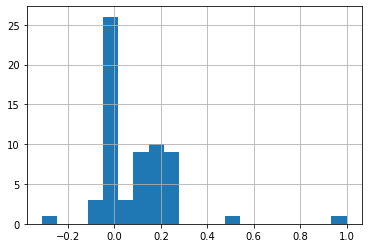

In [ ]:
tweets_df['polarity'].hist(bins=20)

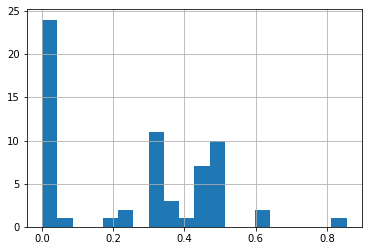

In [ ]:
tweets_df['subjectivity'].hist(bins=20)

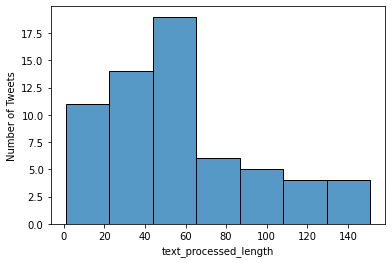

In [ ]:
#Data visualization of text_length.
sb3 = sns.histplot(data=tweets_df, x='text_processed_length').set(ylabel = 'Number of Tweets')

#### Add sentiment score 2: Using google text analytics

Next, use Google Text API to analyze the Tweet text and get score corresponding to the sentiment in the text

For each row in the dataframe:
  - Pick out the value in the 'Tweet Text' column
  - Assign metadata parameters (content, type, language, encoding_type)
  - Invoke the analyze_sentiment API using the client instantiated above 
  - Use the response from the analyze_sentiment API call to obtain score and magnitude values
  - Invoke the analyze_entities and the google detected entities related are collected in a set and added to the dataframe
  - The language is added to the dataframe
  - Invoke classify_text to detect the category of the text, we also add some error handling as google's API throws an error when the text has less than 20 tokens

In [ ]:
#google sentiment function
def googleSentiment(df):

  # setup a client for the service
  client = language_v1.LanguageServiceClient()

  # specify the type and language of the document we want to analyse
  type_ = enums.Document.Type.PLAIN_TEXT
  language = "en"
  result_df_score_mag = pd.DataFrame(columns= ['tweet_num','score','magnitude'])

  #repeat in all rows in dataframe
  for index, row in df.iterrows():
    text_content = row['content']

    # assign metadata parameters
    document = {"content": text_content, "type": type_, "language": language}
    encoding_type = enums.EncodingType.UTF8

    # invoke the analyze_sentiment API
    response = client.analyze_sentiment(document, encoding_type)
    # invoke the analyze_entities API for bonus 2
    # i.e. adding insight regarding what the tweet is about. Example: Phone, Organisation etc.
    entities_response = client.analyze_entities(document, encoding_type)

    # invoke classify_text API for bonus 2
    # i.e. adding insight regarding category, such as finance, investing, currencies etc,
    detected_categories = None
    try:
      categories_response = client.classify_text(document)
      
      categories = set()
      for category in categories_response.categories:
        categories.add(category.name)

      detected_categories = ",".join(categories)
    
    #if we cannot find any categories, we just pass it
    except:
      pass

    # simple method used to slow down the requests due to too many requests error
    sleep(0.2) 
    
    entity_types = set()
    for entity in entities_response.entities:
      entity_types.add(enums.Entity.Type(entity.type).name)

    # store the score and magnitude values into result_df_score_mag
    temp_df = pd.DataFrame([[index,
                            response.document_sentiment.score,
                            response.document_sentiment.magnitude, 
                            entities_response.language,
                            ','.join(entity_types),
                            detected_categories
                            ]], 
                          
                            columns=['tweet_num',
                                    'score',
                                    'magnitude', 
                                    'google_language',
                                    'google_entities',
                                    'google_categories'])
    result_df_score_mag = result_df_score_mag.append(temp_df, ignore_index=True)

  return result_df_score_mag

In [ ]:
#Add google sentiment data
result_df = googleSentiment(tweets_df)

In [ ]:
result_df.head()

,tweet_num,score,magnitude,google_language,google_entities,google_categories
0,5127,-0.2,0.2,en,"OTHER,LOCATION,ORGANIZATION",/Finance/Investing/Currencies & Foreign Exchange
1,5128,0.0,1.0,en,"PERSON,LOCATION,OTHER,ORGANIZATION",
2,5129,0.0,0.4,en,"OTHER,LOCATION,NUMBER",None
3,5130,0.0,0.4,en,"OTHER,LOCATION,NUMBER",None
4,5131,-0.5,0.5,en,"OTHER,ORGANIZATION",/Finance/Investing


In [ ]:
#merge result_df from google sentiment analysis with tweets_df
tweets_df = tweets_df.merge(result_df, how='inner', on=result_df.index).drop('key_0', axis=1)

In [ ]:
tweets_df.head()

,index,crypto,url,date,id,username,content,text_length,content_processed,polarity,subjectivity,label,text_processed_length,tweet_num,score,magnitude,google_language,google_entities,google_categories
0,1799,bitcoin,https://twitter.com/business/status/1340922472...,2020-12-21 07:30:05,1340922472351330307,business,JPMorgan says the odds of a Bitcoin correction...,161,jpmorgan says odds bitcoin correction would in...,0.037500,0.637500,4,112,5127,-0.2,0.2,en,"OTHER,LOCATION,ORGANIZATION",/Finance/Investing/Currencies & Foreign Exchange
1,7472,btc,https://twitter.com/Investingcom/status/134099...,2020-12-21 12:11:41,1340993341916393472,Investingcom,Here are https://t.co/HMaYPuSux7's #Top5Things...,272,monday deal agreed new strain found uk st...,0.136364,0.454545,4,114,5128,0.0,1.0,en,"PERSON,LOCATION,OTHER,ORGANIZATION",
2,7471,btc,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...,0.136364,0.454545,4,59,5129,0.0,0.4,en,"OTHER,LOCATION,NUMBER",None
3,5508,bitcoin,https://twitter.com/Investingcom/status/134102...,2020-12-21 14:06:15,1341022172014325761,Investingcom,*Bitcoin slumps 6% as new COVID-19 strain upse...,119,bitcoin slumps new covid strain upsets wider ...,0.136364,0.454545,4,59,5130,0.0,0.4,en,"OTHER,LOCATION,NUMBER",None
4,164,bitcoin,https://twitter.com/WSJ/status/134159061918200...,2020-12-23 03:45:03,1341590619182002177,WSJ,Ripple said it will defend itself against a la...,199,ripple said defend lawsuit sec claims company ...,-0.050000,0.300000,2,121,5131,-0.5,0.5,en,"OTHER,ORGANIZATION",/Finance/Investing


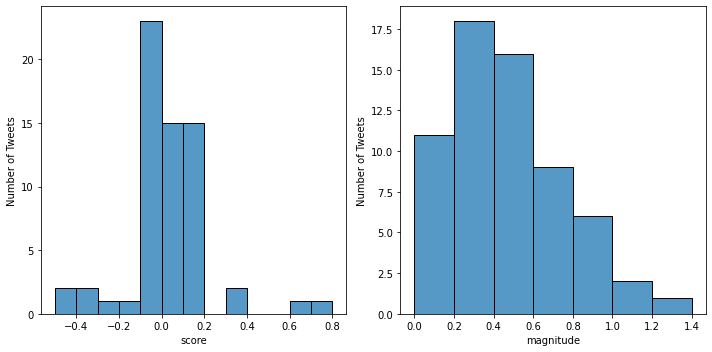

In [ ]:
#check score and magnitude data by histogram.
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.histplot(data = tweets_df, x='score', ax=axs[0]).set(ylabel = 'Number of Tweets')
sns.histplot(data = tweets_df, x='magnitude', ax=axs[1]).set(ylabel = 'Number of Tweets')
fig.tight_layout()

### Fuzzy logic

Reference:

* def fuzzyLogic(self):

#### Error handling

In [ ]:
#By fuzzy logic, converting google sentiment (score, magnitude) into
#one indicator of 'strength' between 0 (negative) - 100 (positive).
#'strength' can be used for trading buy/sell recommendation.
#i.e. if strength > certain figure, buy.
#     if strength < certain figure, sell.

#if no text data available, just return nan for sentiment indicator
if tweets_df.iloc[0,:].isna().sum() > 5:
  
  sentiment_dailyavg_df = pd.DataFrame(data=[['BTC-USD',np.nan]],
                                                    index=tweets_df['date'],
                                                    columns=['currency','strength'])
  sentiment_dailyavg_df.index.names = ['Date']

#### Set up of fuzzy logic

In [ ]:
#else, implement fuzzy logic and return sentiment indicator value of 0-100

#check if there is relevant twitter text within the day.
#If no tweet, we fill sentiment data as N/A
#if len(twitterAgent.tweets_df) == 0:
#  twitterAgent.sentiment_dailyavg_df = pd.DataFrame[columns=['currency','strength']]

#Antecedent: score and magnitude 
#Consequence: sentiment strength

#Setup:
#- Score is -1 to 1 with 0.1 step
#- Magnitude is 0 to 2.0 with 0.1 step
#- Strength is 0 to 100, with step = 1
score = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'score')
magnitude = ctrl.Antecedent(np.arange(0, 2.1, 0.1), 'magnitude')
strength = ctrl.Consequent(np.arange(0, 101, 1), 'strength')

#Setting membership function for the score
score['low'] = fuzz.trimf(score.universe, [-1, -1, 0])
score['moderate'] = fuzz.trimf(score.universe, [-1.0, 0, 1.0])
score['high'] = fuzz.trimf(score.universe, [0, 1, 1])

#setting membership function for the magnitude
magnitude['low'] = fuzz.trimf(magnitude.universe, [0, 0, 1.0])
magnitude['moderate'] = fuzz.trimf(magnitude.universe, [0, 1.0, 2.0])
magnitude['high'] = fuzz.trimf(magnitude.universe, [1.0, 2.0, 2.0])

#setting membership function for the strength
strength['low'] = fuzz.trimf(strength.universe, [0, 0, 50])
strength['moderate'] = fuzz.trimf(strength.universe, [0, 50, 100])
strength['high'] = fuzz.trimf(strength.universe, [50, 100, 100])

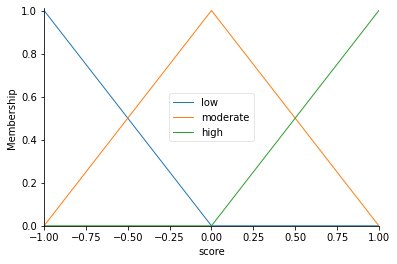

In [ ]:
score.view()

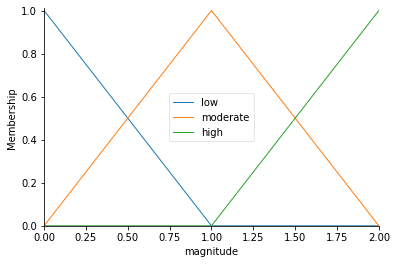

In [ ]:
magnitude.view()

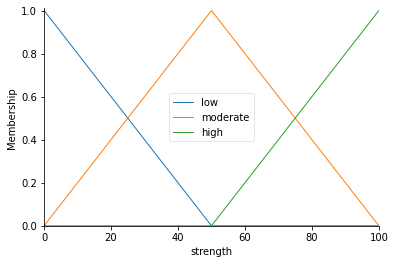

In [ ]:
strength.view()

#### Create rules for fuzzy logic

In [ ]:
#The rules are as follows:
#- Strength will be high if
#  - Both score and magnitude are high
#  - Score is high and magnitude is average
#- Strength will be moderate if
#  - Score is high but magnitude is low
#  - Both score and magnitude is average
#  - Score is average but magnitude is high
#- Strength will be low if
#  - Score is average and magnitude is low
#  - Score is low
rule1 = ctrl.Rule(score['high'] & magnitude['high'], strength['high'])
rule2 = ctrl.Rule(score['high'] & magnitude['moderate'], strength['high'])

rule3 = ctrl.Rule(score['high'] & magnitude['low'], strength['moderate'])
rule4 = ctrl.Rule(score['moderate'] & magnitude['moderate'], strength['moderate'])
rule5 = ctrl.Rule(score['moderate'] & magnitude['high'], strength['moderate'])

rule6 = ctrl.Rule(score['moderate'] & magnitude['low'], strength['low'])
rule7 = ctrl.Rule(score['low'], strength['low'])

analysis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
analysis = ctrl.ControlSystemSimulation(analysis_ctrl)

#### Compute strength from score and magnitude by fuzzy-logic

In [ ]:
# create empty dataframe to store the results of usefulness
result_df = pd.DataFrame(columns= ['date','strength'])

for index, row in tweets_df.iterrows():
  analysis.input['score'] = row['score']
  analysis.input['magnitude'] = row['magnitude']

  # crunch the numbers
  analysis.compute()

  tempGrade = analysis.output['strength']

  # store Usefulness grade into result_df
  temp_df = pd.DataFrame([tempGrade], columns=['strength'])
  temp_df['date'] = row['date']
  result_df = result_df.append(temp_df, ignore_index=True)

result_df.columns = ['Date','strength']
result_df['Date'] = pd.to_datetime(result_df['Date'])

In [ ]:
result_df

,Date,strength
0,2020-12-21 07:30:05,32.745098
1,2020-12-21 12:11:41,50.000000
2,2020-12-21 14:06:15,41.219512
3,2020-12-21 14:06:15,41.219512
4,2020-12-23 03:45:03,44.047619
...,...,...
58,2020-12-31 04:45:35,49.047619
59,2020-12-31 13:17:19,48.142361
60,2020-12-31 13:35:07,49.297800
61,2020-12-31 15:05:30,41.219512


#### Create daily average score of twitter sentiment for the use of daily trading

In [ ]:
#create daily average score of twitter sentiment
sentiment_dailyavg_df = result_df.resample('d', on='Date').mean()
sentiment_dailyavg_df.index = sentiment_dailyavg_df.index.strftime('%Y-%m-%d')
sentiment_dailyavg_df['currency'] = 'BTC-USD'
sentiment_dailyavg_df = sentiment_dailyavg_df[['currency','strength']]

#convert the data type of index 'yyyy-mm-dd' into datetime
sentiment_dailyavg_df.index = pd.to_datetime(sentiment_dailyavg_df.index)

In [ ]:
sentiment_dailyavg_df

,currency,strength
Date,,
2020-12-21,BTC-USD,41.296031
2020-12-22,BTC-USD,NaN
2020-12-23,BTC-USD,30.357143
2020-12-24,BTC-USD,35.064607
2020-12-25,BTC-USD,29.720910
2020-12-26,BTC-USD,37.464972
2020-12-27,BTC-USD,36.766717
2020-12-28,BTC-USD,59.208333
2020-12-29,BTC-USD,35.709848


#### Data cleaning and preprocessing

In [ ]:
#store twitter sentiment indicator
try:
  sentiment_history_df = pd.concat([sentiment_history_df,
                                    sentiment_dailyavg_df])
#if no sentiment_history_df, set up dataframe by today's data
except:
  sentiment_history_df = sentiment_dailyavg_df

sentiment_history_df.index.names = ['Date']

#set start and end day in the data
startday = sentiment_history_df.index[0]
endday = sentiment_history_df.index[-1]
#Change data from 250 trading days per year excluding holidays to 365 days data.
date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
date_df = pd.DataFrame(date_index)
date_df.columns = ['Date']
date_df['Date'] = pd.to_datetime(date_df['Date']) 

#Add saturday and sunday.
sentiment_history_df = sentiment_history_df.reset_index()
sentiment_history_df = date_df.merge(sentiment_history_df, on='Date', how='outer')
#change datetype of Date
sentiment_history_df['Date'] = sentiment_history_df['Date'].astype("datetime64")
#executing ffill (if no price is available, just filling by previous price data)
sentiment_history_df['currency'] = sentiment_history_df['currency'].fillna(method='ffill')
#set Date as index.
sentiment_history_df = sentiment_history_df.set_index(['Date'])
#for keeping data cleanness, executing elimination of duplicated day data
sentiment_history_df = sentiment_history_df[~sentiment_history_df.index.duplicated(keep='first')]

In [ ]:
sentiment_history_df

,currency,strength
Date,,
2020-12-21,BTC-USD,41.296031
2020-12-22,BTC-USD,NaN
2020-12-23,BTC-USD,30.357143
2020-12-24,BTC-USD,35.064607
2020-12-25,BTC-USD,29.720910
2020-12-26,BTC-USD,37.464972
2020-12-27,BTC-USD,36.766717
2020-12-28,BTC-USD,59.208333
2020-12-29,BTC-USD,35.709848


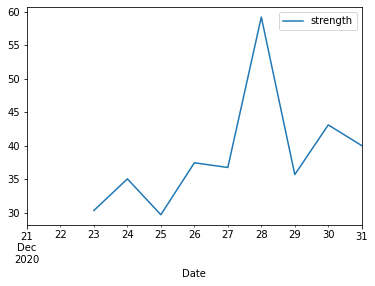

In [ ]:
sentiment_history_df.plot()

### Convert strength into buy/sell signal

Reference:
* def signalGeneration(self, sentiment_history_df, day, data_window=1, buy_level=40, sell_level=20):
* Broker agent (price acquisition function only)

#### Referring to the Broker agent relevant to the bitcoin price acquisition.

In [ ]:
class Broker(object):

  #get whole price from SQL data library.
  @staticmethod
  def getPriceFromDataLibrary():
    dbConnection = sqlEngine.connect()
    price_df = pd.read_sql("select * from YahooData", dbConnection)
    dbConnection.close()

    price_df = price_df.set_index('Date')[['Close','Volume']]
    price_df.columns = ['close','volume']
    return price_df

  @staticmethod
  def addPctChg(df):
    df = df.copy()
    #calculate % changes
    df['pct_change'] = df['close'].pct_change()
    #In the backtesting, log return is useful, because we can calculate accumulate return %
    #just by adding daily return %. np.log1p calculate log(1+x)
    df['log_return'] = np.log1p(df['pct_change'])

    return df

  @staticmethod
  def histPriceAcquisition():
    longhist_price_df = Broker.getPriceFromDataLibrary()
    #add pct change and log_return
    longhist_price_df = Broker.addPctChg(longhist_price_df)

    #assure all 365 days are within the data index.
    startday = longhist_price_df.index[0]
    endday = longhist_price_df.index[-1]

    date_index = pd.date_range(start = startday, end = endday, freq="D").strftime('%Y-%m-%d')
    date_df = pd.DataFrame(date_index)
    date_df.columns = ['Date']
    date_df['Date'] = pd.to_datetime(date_df['Date']) 
    longhist_price_df = longhist_price_df.reset_index()
    longhist_price_df = date_df.merge(longhist_price_df, on='Date', how='outer')
    #change datetype of Date
    longhist_price_df['Date'] = longhist_price_df['Date'].astype("datetime64")
    #executing ffill (if no price is available, just filling by previous price data)
    longhist_price_df = longhist_price_df.fillna(method='ffill')
    longhist_price_df = longhist_price_df.set_index('Date')

    #Broker.longhist_price_df is created under Broker class.
    Broker.longhist_price_df = longhist_price_df[['close','volume','pct_change','log_return']]

  ########################
  #Getter functions
  ########################

  #Those can become interface
  #for communication among
  #different agents
  @staticmethod
  def longHistoryPriceGetter():
    return Broker.longhist_price_df

In [ ]:
Broker.histPriceAcquisition()

In [ ]:
Broker.longHistoryPriceGetter().head()

,close,volume,pct_change,log_return
Date,,,,
2014-09-17,457.334015,21056800.0,NaN,NaN
2014-09-18,424.440002,34483200.0,-0.071926,-0.074643
2014-09-19,394.795990,37919700.0,-0.069843,-0.072402
2014-09-20,408.903992,36863600.0,0.035735,0.035111
2014-09-21,398.821014,26580100.0,-0.024659,-0.024968


#### Converting strength into buy/sell signal

In [ ]:
#set parameters.
data_window=5
buy_level=40
sell_level=20

In [ ]:
sentiment_df = sentiment_history_df.copy()
#for keeping data cleanness, executing elimination of duplicated day data
sentiment_df = sentiment_df[~sentiment_df.index.duplicated(keep='first')]

#rolling x days moving average
sentiment_df['strength_ma'] = sentiment_df['strength'].rolling(window=data_window,
                                                              min_periods=1).mean()

#create trading signal
#buy signal
sentiment_df['long_signal'] = np.where(sentiment_df['strength_ma'] > buy_level, 1, 0)

#sell signal
sentiment_df['short_signal'] = np.where(sentiment_df['strength_ma'] < sell_level, 1, 0)

In [ ]:
sentiment_df

,currency,strength,strength_ma,long_signal,short_signal
Date,,,,,
2020-12-21,BTC-USD,41.296031,41.296031,1,0
2020-12-22,BTC-USD,NaN,41.296031,1,0
2020-12-23,BTC-USD,30.357143,35.826587,0,0
2020-12-24,BTC-USD,35.064607,35.572593,0,0
2020-12-25,BTC-USD,29.720910,34.109673,0,0
2020-12-26,BTC-USD,37.464972,33.151908,0,0
2020-12-27,BTC-USD,36.766717,33.874870,0,0
2020-12-28,BTC-USD,59.208333,39.645108,0,0
2020-12-29,BTC-USD,35.709848,39.774156,0,0


In [ ]:
agent3_hist_signal_df = pd.DataFrame()

In [ ]:
#add price close in tradesignal_df
tradesignal_df = sentiment_df
tradesignal_df.index.names = ['Date']
tradesignal_df = tradesignal_df.reset_index()
tradesignal_df['Date'] = tradesignal_df['Date'].astype(str)
price_df = Broker.longHistoryPriceGetter()
price_df = price_df.reset_index()
price_df['Date'] = price_df['Date'].astype(str)
tradesignal_df = tradesignal_df.merge(price_df[['Date','close']],how='inner', on='Date')
tradesignal_df['Date'] = pd.to_datetime(tradesignal_df['Date'])
tradesignal_df = tradesignal_df.set_index('Date')
tradesignal_df = tradesignal_df[['close','long_signal','short_signal']]

#update twitter signal history data
if len(agent3_hist_signal_df) == 0:
  agent3_hist_signal_df = tradesignal_df
else:
  agent3_hist_signal_df = pd.concat([agent3_hist_signal_df,
                                              tradesignal_df])
  
agent3_hist_signal_df = Broker.addPctChg(agent3_hist_signal_df)
#for keeping data cleanness, executing elimination of duplicated day data
agent3_hist_signal_df = agent3_hist_signal_df[~agent3_hist_signal_df.index.duplicated(keep='first')]

In [ ]:
agent3_hist_signal_df

,close,long_signal,short_signal,pct_change,log_return
Date,,,,,
2020-12-21,22803.082031,1,0,NaN,NaN
2020-12-22,23783.029297,1,0,0.042974,0.042077
2020-12-23,23241.345703,0,0,-0.022776,-0.023039
2020-12-24,23735.949219,0,0,0.021281,0.021058
2020-12-25,24664.791016,0,0,0.039132,0.038386
2020-12-26,26437.037109,0,0,0.071853,0.069389
2020-12-27,26272.294922,0,0,-0.006231,-0.006251
2020-12-28,27084.808594,0,0,0.030927,0.030458
2020-12-29,27362.437500,0,0,0.010250,0.010198
